# Task 2: Create a K-means Clustering Algorithm to group customers of a retail store based on their purchase history

## 1. Importing the Libraries

In [1]:
# Importing necessary libraries for the ML Project
import numpy as np  # For numerical operations, array handling, and mathematical computations
import pandas as pd  # For data loading, manipulation, and analysis using DataFrames

import matplotlib.pyplot as plt  # For visualizing data through various plots and charts

from sklearn.preprocessing import StandardScaler  # For standardizing features by removing the mean and scaling to unit variance
from sklearn.cluster import KMeans  # K-Means clustering algorithm for unsupervised learning
from sklearn.metrics import silhouette_score  # To evaluate the quality of clustering (how well-separated the clusters are)

## 2. Loading and Viewing (Inspecting) the DataSet

In [2]:
# Loading the customer dataset from a CSV file into a DataFrame
df = pd.read_csv('Mall_Customers.csv')

In [3]:
# Displaying the first 10 rows of the dataset to get an initial look at the data
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [4]:
# Returns a tuple indicating (number of rows, number of columns)
df.shape

(200, 5)

In [5]:
# Display all column names in the DataFrame to understand available features
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [6]:
# Provide the summary of the DataFrame
df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
# Tells us how many null values are there in a column
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [8]:
# Provide the descriptive statistics for numeric columns in the DataSet
df.describe() 

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## 3. Exploratory Data Analysis (EDA)

### 3.1 Demographic Analysis

#### 3.1.1 Gender Distribution

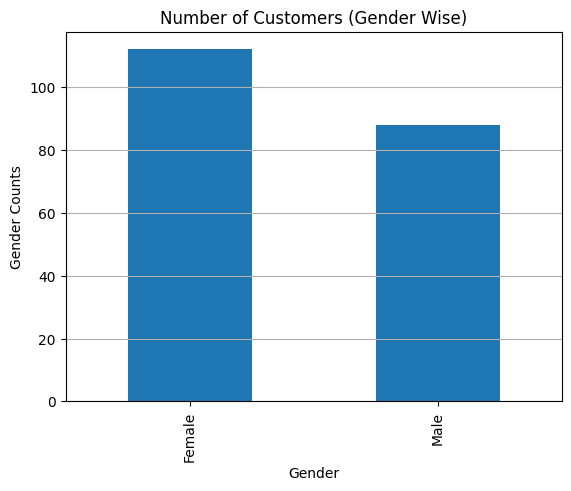

In [9]:
# Calculate the count of each gender category in the 'Gender' column
# This helps understand the distribution of customers by gender

gender_count = df['Gender'].value_counts()
gender_count.plot(kind='bar')  
plt.title("Number of Customers (Gender Wise)")
plt.xlabel('Gender')
plt.ylabel("Gender Counts")
plt.grid(axis='y')
plt.show() 

### 3.2 Purchase Behavior Analysis

#### 3.2.1 Income Distribution

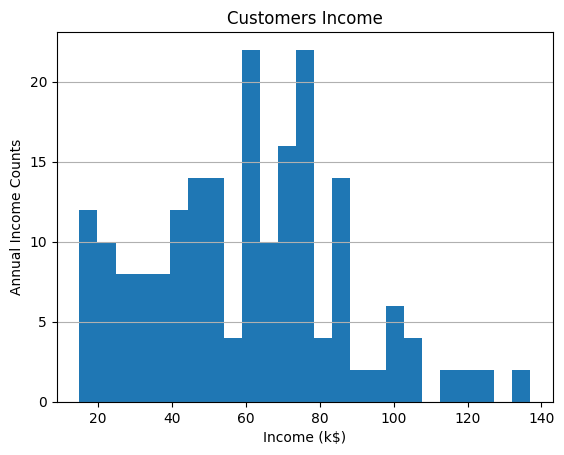

In [10]:
# Plot a histogram of customer annual incomes in thousands ($)
# Histograms help visualize the distribution and frequency of continuous data

df['Annual Income (k$)'].plot(kind= 'hist', bins = 25)
plt.title("Customers Income")
plt.xlabel("Income (k$)")
plt.ylabel("Annual Income Counts")
plt.grid(axis = 'y')
plt.show()

#### 3.2.2 Spending Score Distribution

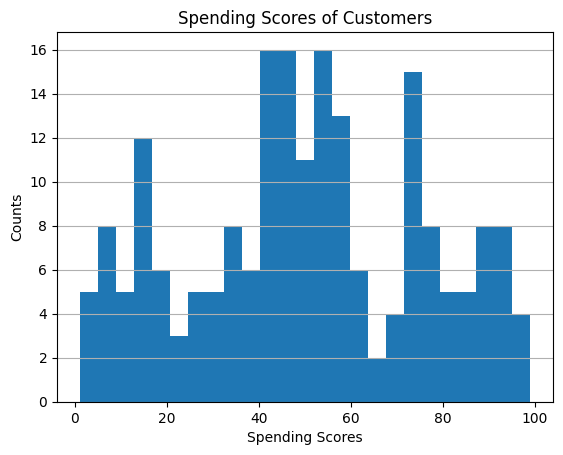

In [11]:
# Visualize the distribution of customer spending scores using a histogram
# Spending scores (1-100) represent customer purchasing behavior, where higher = more spending

df['Spending Score (1-100)'].plot(kind = 'hist', bins = 25)
# Using 25 bins provides optimal granularity to identify spending patterns across the 1-100 range

plt.title("Spending Scores of Customers")
plt.xlabel("Spending Scores")
plt.ylabel("Counts")
plt.grid(axis = 'y')
plt.show()

#### 3.2.3 Income vs Spending Relationship

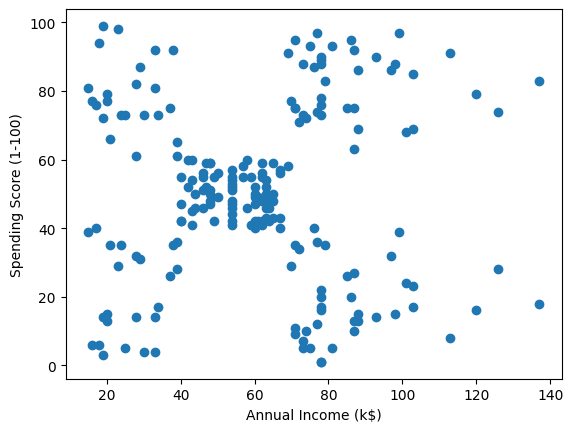

In [12]:
# Create a scatter plot to examine the relationship between income and spending behavior
# This helps by identify patterns, correlations, or segments in customer spending habits

plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'])
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

## 4. Data Preprocessing

### 4.1 Feature Engineering

In [13]:
# Dropping the CustomerID column as it's typically a:
# Unique identifier without predictive values

df = df.drop(columns=['CustomerID']) 

In [14]:
features_2d = ['Annual Income (k$)', 'Spending Score (1-100)']
features_3d = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

### Why was the 'Gender' column not used for clustering?

1. **Not Numerical by Default**: K-Means is a distance-based algorithm and requires numerical inputs. Encoding gender (e.g., Male = 0, Female = 1) could introduce artificial numerical meaning that doesn’t accurately reflect real-world differences.

2. **Low Predictive Value**: Gender alone is unlikely to be a strong differentiator in customer purchasing behavior compared to features like Income, Spending Score, or Age.

### 4.2 Feature Scaling

In [15]:
# Selecting features for Clustering 

# Features like 'Annual Income' and 'Spending Score' have different units and scales.
# KMeans clustering uses distance metrics (like Euclidean distance), which are sensitive to scale.
# To ensure no feature dominates due to its larger scale, we standardize features to have mean=0 and std=1.

scaler_2d = StandardScaler()  # Initializing scaler for 2D features
scaler_3d = StandardScaler()  # Initializing scaler for 3D features

X_scaled_2d = scaler_2d.fit_transform(df[features_2d])  # Standardizing 2D feature set
X_scaled_3d = scaler_3d.fit_transform(df[features_3d])  # Standardizing 3D feature set

## 5. Cluster Optimization

### 5.1 Silhouette Analysis

In [16]:
# We want to find the optimal number of clusters (k) for KMeans.
# Silhouette score measures how well each data point fits within its cluster vs. others.
# Scores range from -1 to 1, where higher is better clustering.

ks = range(2, 11)
silhouette_scores_2d = []
silhouette_scores_3d = []

In [17]:
for k in ks:
    km_2d = KMeans(n_clusters = k, random_state = 42, n_init = 10)

    # Fit KMeans on the standardized 2D feature data and predict cluster labels
    labels_2d = km_2d.fit_predict(X_scaled_2d)

    # Calculate the silhouette score for these clusters
    # This score quantifies how well-separated and cohesive the clusters are
    score_2d = silhouette_score(X_scaled_2d, labels_2d)

    # Storing the silhouette score to analyze later which k is the best
    silhouette_scores_2d.append(score_2d)


    km_3d = KMeans(n_clusters=k, random_state = 42, n_init = 10)
    labels_3d = km_3d.fit_predict(X_scaled_3d)
    score_3d = silhouette_score(X_scaled_3d, labels_3d)
    silhouette_scores_3d.append(score_3d)

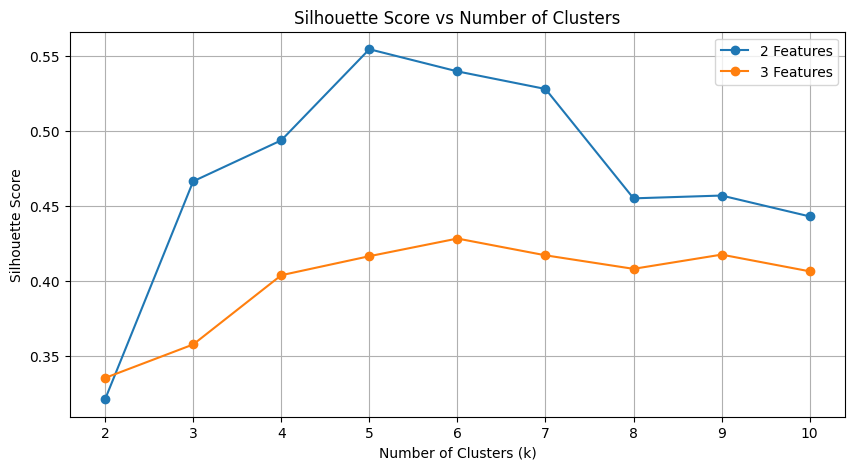

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(ks, silhouette_scores_2d, marker = 'o', label='2 Features')
plt.plot(ks, silhouette_scores_3d, marker = 'o', label='3 Features')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Select the optimal number of clusters (k) that maximize the silhouette score
# We pick the k with the highest silhouette score for both 2D and 3D feature sets

best_k_2d = ks[np.argmax(silhouette_scores_2d)]
best_k_3d = ks[np.argmax(silhouette_scores_3d)]

In [20]:
print(f"Best k for 2 features: {best_k_2d}, Silhouette Score: {max(silhouette_scores_2d):.4f}")
print(f"Best k for 3 features: {best_k_3d}, Silhouette Score: {max(silhouette_scores_3d):.4f}")

Best k for 2 features: 5, Silhouette Score: 0.5547
Best k for 3 features: 6, Silhouette Score: 0.4284


- ### **Although I have used the Silhouette Score to find the best number of clusters (k), I want to validate this result using the Elbow Method as well.**
- ### **The Elbow Method helps me visually identify the point where increasing the number of clusters doesn’t significantly improve the clustering quality, by looking at the Within-Cluster Sum of Squares (WCSS).**

- ### **I am applying the Elbow Method only on the 2D features (Annual Income and Spending Score) because these two are easier to interpret and visualize for customer segmentation.**

### 5.2 Elbow Method (Validation Step)

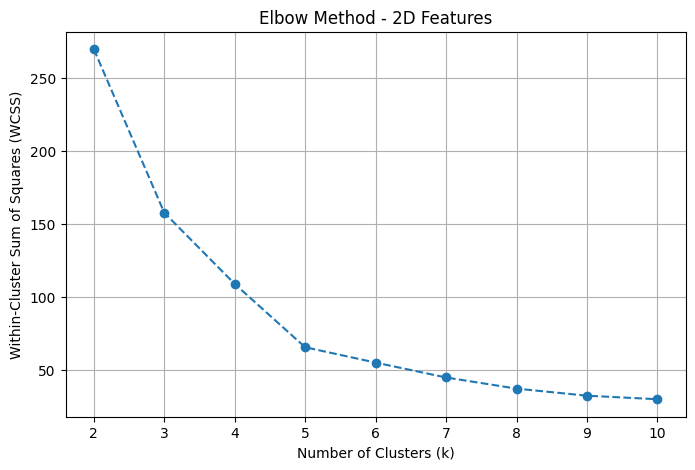

In [21]:
wcss_2d_values = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_2d)
    wcss_2d_values.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(ks, wcss_2d_values, marker='o', linestyle='--')
plt.title("Elbow Method - 2D Features")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid(True)
plt.show()

## 6. Final Model Training & Cluster Visualization

**Now that I have identified the optimal number of clusters (k) using both the Silhouette Score and validated it with the Elbow Method, I will proceed with training the final KMeans model.**

### 6.1 Standardized Scale Visualization

- **I’m applying KMeans on the standardized 2D features (Annual Income & Spending Score), because clustering algorithms like KMeans are sensitive to feature scale.**

- **After clustering, I will visualize the clusters and their centroids.**
- **Although the data is standardized, I will clearly label the axes to reflect that.**
- **This plot will help me visually understand how customers are grouped based on their income and spending behavior.**

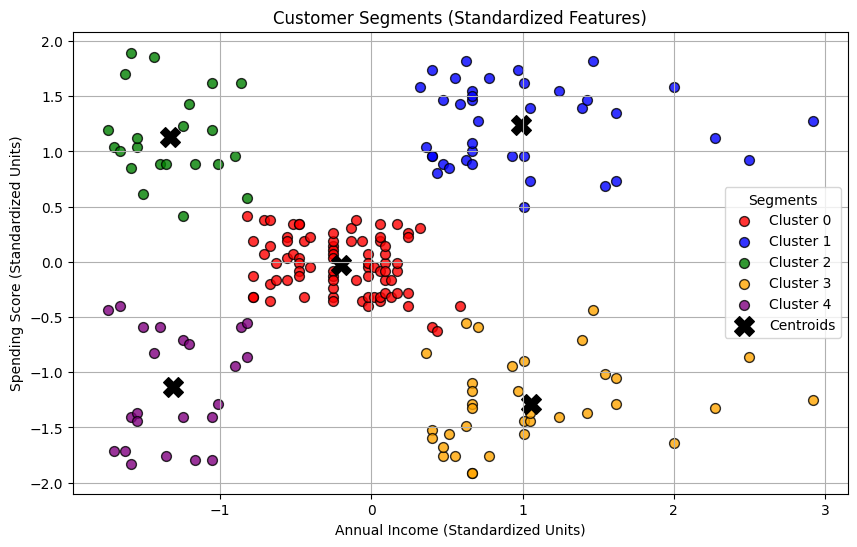

In [22]:
# Now that I have determined the optimal number of clusters (k) using the Silhouette Score,
# and also validated it using the Elbow Method (for 2D features), I will perform the final KMeans clustering.

# I will fit the final KMeans model using the standardized 2D features — 'Annual Income' and 'Spending Score'.
# Standardization ensures that the distance-based clustering isn’t biased toward one feature due to scale.

# Fit final model
kmeans_final = KMeans(n_clusters=best_k_2d, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled_2d)
centroids = kmeans_final.cluster_centers_

# Adding cluster labels to original DataFrame for profiling, I will be using it in the later part, So doing it beforehand
df['Cluster'] = cluster_labels


plt.figure(figsize=(10,6))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']

colors = colors[:best_k_2d]

for i in range(best_k_2d):
    plt.scatter(X_scaled_2d[cluster_labels == i, 0],
                X_scaled_2d[cluster_labels == i, 1],
                s=50, c=colors[i], label=f'Cluster {i}', 
                edgecolor='black', alpha=0.8)
plt.scatter(centroids[:,0], centroids[:,1], s=200, marker='X',
            c='black', label='Centroids')
plt.title("Customer Segments (Standardized Features)")
plt.xlabel("Annual Income (Standardized Units)")
plt.ylabel("Spending Score (Standardized Units)")
plt.legend(title='Segments')
plt.grid()
plt.show()

### 6.2 Original Scale Visualization

- **Since the KMeans model was trained on standardized data (to ensure fair distance comparisons), the cluster centroids are in standardized units.**
- **However, for better interpretability and to convey real-world meaning to business stakeholders, I've inverse-transformed both the features and centroids.**
- **This lets the visualize customer segments using actual income and spending score values, making the insights more accessible.**

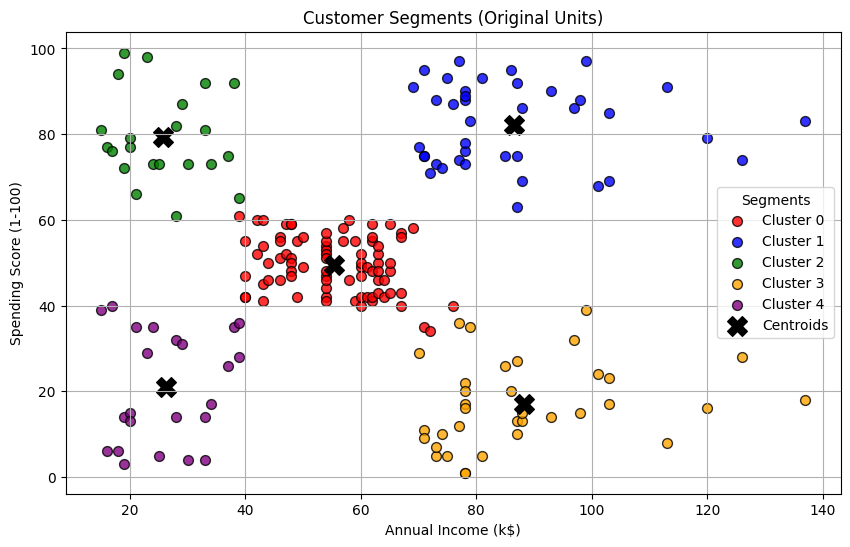

In [23]:
# Inverse transform
# Convert the standardized data and centroids back to the original scale.
# This is important for making the plot interpretable using real-world units (like income in k$)

X_original = scaler_2d.inverse_transform(X_scaled_2d)
centroids_original = scaler_2d.inverse_transform(centroids)

# This plot helps stakeholders better understand the distribution and characteristics
# of customer segments, using actual values of income and spending scores.

plt.figure(figsize=(10,6))

for i in range(best_k_2d):
    plt.scatter(X_original[cluster_labels == i, 0],
                X_original[cluster_labels == i, 1],
                s=50, c=colors[i], label=f'Cluster {i}',
                edgecolor='black', alpha=0.8)
plt.scatter(centroids_original[:,0], centroids_original[:,1],
            s=200, marker='X', c='black', label='Centroids')
plt.title("Customer Segments (Original Units)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend(title='Segments')
plt.grid(True)
plt.show()

## 7. Cluster Interpretation & Profiles

In [24]:
df['Cluster']

0      4
1      2
2      4
3      2
4      4
      ..
195    1
196    3
197    1
198    3
199    1
Name: Cluster, Length: 200, dtype: int32

In [25]:
# Mean profile of each cluster (average income and spending)
cluster_summary = df.groupby('Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()
print("Cluster Summary (Mean Values):")
print(cluster_summary)

# Count of customers per cluster
cluster_counts = df['Cluster'].value_counts().sort_index()
print("\nNumber of customers in each cluster:")
print(cluster_counts)

Cluster Summary (Mean Values):
         Annual Income (k$)  Spending Score (1-100)
Cluster                                            
0                 55.296296               49.518519
1                 86.538462               82.128205
2                 25.727273               79.363636
3                 88.200000               17.114286
4                 26.304348               20.913043

Number of customers in each cluster:
Cluster
0    81
1    39
2    22
3    35
4    23
Name: count, dtype: int64


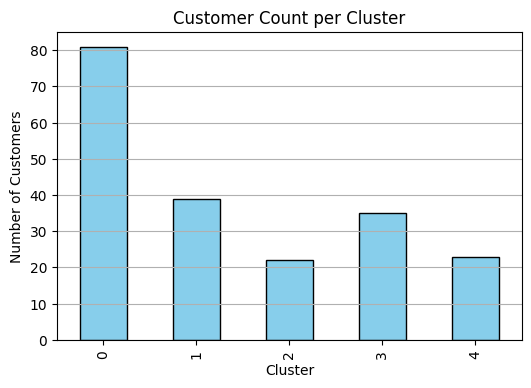

In [26]:
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Customer Count per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.grid(axis='y')
plt.show()

## 8. Business Insights & Strategic Implications

In [27]:
cluster_data = {
    'Cluster': [0, 1, 2, 3, 4],
    'Income Level': ['Mid', 'High', 'Low', 'High', 'Low'],
    'Spending Level': ['Mid', 'High', 'High', 'Low', 'Low'],
    'Description': [
        'Balanced Customers',
        'Ideal Customers',
        'Value Seekers (High Spending, Low Income)',
        'Careful Spenders (High Income, Low Spending)',
        'Low Engagement Customers'
    ]
}

cluster_summary = pd.DataFrame(cluster_data)

cluster_summary

,Cluster,Income Level,Spending Level,Description
0,0,Mid,Mid,Balanced Customers
1,1,High,High,Ideal Customers
2,2,Low,High,"Value Seekers (High Spending, Low Income)"
3,3,High,Low,"Careful Spenders (High Income, Low Spending)"
4,4,Low,Low,Low Engagement Customers


#### After performing the KMeans clustering on the Customer Data, I identified 5 distinct clusters, each representing a group of customers with similar spending habits and income levels:

- **Cluster 0 - Mid-Income, Mid-Spending Customers:** These customers have an average annual income of around $55k and a moderate spending score of around 49. They likely represent the core middle segment—neither too frugal nor extravagant.

- **Cluster 1 - High-Income, High-Spending Customers:** With an average income of $86.5k and a high spending score of 82, these are the most valuable customers. They have the capacity and willingness to spend, making them ideal for premium products and loyalty programs.
            
- **Cluster 2 - Low-Income, High-Spending Customers:** This group, earning about $25.7k but spending at a high level (79.4), could represent younger consumers, students, or impulsive buyers.

- **Cluster 3 - Cluster 3 – High-Income, Low-Spending Customers:** With the highest income (~$88.2k) but a low spending score (17.1), these customers are financially well-off but conservative or disengaged in spending. They may require targeted trust-building or value-driven marketing to convert.

- **Cluster 4 – Low-Income, Low-Spending Customers:** This segment earns the least ($26.3k) and spends the least (20.9). They are likely price-sensitive customers or individuals with limited purchasing power.

#### How can these clusters help in strategy?
- **Targeted Marketing:** Cluster 1 could be ideal for premium product promotions.
- **Customer Retention:** Cluster 2 might require loyalty offers due to high spending but low income.
- **Cost Efficiency:** Cluster 4 may be less profitable; consider re-engagement or cost-saving strategies.


## 9. Exporting Final Clustered Data for Submission

In [28]:
df.to_csv('customer_segments_submission.csv', index=False)

In [29]:
submission_df = pd.read_csv('customer_segments_submission.csv')
submission_df.head(10)

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,Male,19,15,39,4
1,Male,21,15,81,2
2,Female,20,16,6,4
3,Female,23,16,77,2
4,Female,31,17,40,4
5,Female,22,17,76,2
6,Female,35,18,6,4
7,Female,23,18,94,2
8,Male,64,19,3,4
9,Female,30,19,72,2
